# Проверка работы нейросети для областей одинаковых товаров
рисование картинок   
вычисление symmetric_best_dice   

loaded from D:\Programming\Braille\Data\NN_results/retina_chars_b24228.param.txt
Model loaded


d:\programming\3rd_party\pytorch\pytorch_ovod_master\torch\nn\functional.py:2020: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
d:\programming\3rd_party\pytorch\pytorch_ovod_master\torch\nn\functional.py:2092: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
d:\programming\3rd_party\pytorch\pytorch_ovod_master\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


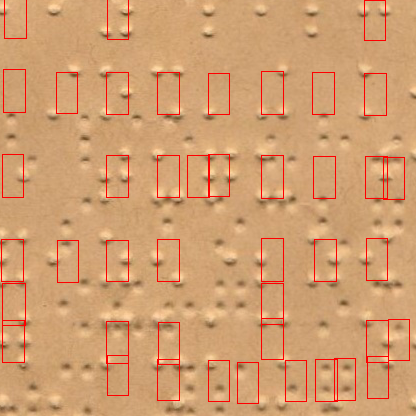

In [2]:
#!/usr/bin/env python
# coding: utf-8

# # Ïðîâåðêà ðàáîòû íåéðîñåòè äëÿ îáëàñòåé îäèíàêîâûõ òîâàðîâ
# ðèñîâàíèå êàðòèíîê
# âû÷èñëåíèå symmetric_best_dice

# In[1]:


from ovotools.params import AttrDict
import sys
sys.path.append('../..')
import local_config
from os.path import join
model_name = 'NN_results/retina_chars_b24228'
model_fn = join(local_config.data_path, model_name)

params = AttrDict.load(model_fn + '.param.txt', verbose = True)
model_fn += '/models/02500.t7'
#params.data.net_hw = (416, 416) #(512,768) ###### (1024,1536) #
params.data.batch_size = 1 #######

import torch
import ignite

device = 'cuda:0'


# In[3]:

import DSBI_invest.data
import create_model_retinanet

model, collate_fn, loss = create_model_retinanet.create_model_retinanet(params, phase='train', device=device)
model = model.to(device)
model.load_state_dict(torch.load(model_fn))
model.eval()
print("Model loaded")

train_loader, (val_loader1, val_loader2) = DSBI_invest.data.create_dataloaders(params, collate_fn)
val_loader1_it = iter(val_loader1)
batch = next(val_loader1_it)
data, target = ignite.engine._prepare_batch(batch, device=device)

with torch.no_grad():
    (loc_preds, cls_preds) = model(data.to(device))

loss_val = loss((loc_preds, cls_preds), target)
loss_val, loss.get_dict()

import PIL
import PIL.ImageDraw

import numpy as np
def TensorToPilImage(tensor, params):
    vx_np = tensor.cpu().numpy().copy()
    vx_np *= np.asarray(params.data.std)[:, np.newaxis, np.newaxis]
    vx_np += np.asarray(params.data.mean)[:, np.newaxis, np.newaxis]
    vx_np = vx_np.transpose(1,2,0)*255
    return PIL.Image.fromarray(vx_np.astype(np.uint8))

img = TensorToPilImage(data[0], params)
w,h = img.size

cls_thresh = 0.1
nms_thresh = 0.2

encoder = loss.encoder
boxes, labels = encoder.decode(loc_preds[0].cpu().data, cls_preds[0].cpu().data, (w,h),
                              cls_thresh = cls_thresh, nms_thresh = nms_thresh)

print

draw = PIL.ImageDraw.Draw(img)
for box in boxes:
    draw.rectangle(list(box), outline='red')
img


